## Подключаем необходимые модули

In [1]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.5 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/DanilOmshin/neural_network.git

Cloning into 'neural_network'...
remote: Enumerating objects: 2555, done.
remote: Total 2555 (delta 0), reused 0 (delta 0), pack-reused 2555
Receiving objects: 100% (2555/2555), 284.44 MiB | 17.10 MiB/s, done.
Checking out files: 100% (2557/2557), done.


In [3]:
import os
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

from skimage import measure
from skimage.io import imread, imsave, imshow
from skimage.transform import resize
from skimage.filters import gaussian
from skimage.morphology import dilation, disk
from skimage.draw import polygon, polygon_perimeter

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.config.list_physical_devices("GPU") else "OFF" }')

Tensorflow version 2.9.2
GPU is ON


## Подготовим набор данных для обучения

In [4]:
CLASSES = 8 # объекты, присутствующие на сцене и задний фон
# задаём различные цвета
COLORS = ['black', 'red', 'lime',
          'blue', 'orange', 'pink',
          'cyan', 'magenta']

SAMPLE_SIZE = (256, 256) # фиксированный размер входного изображения

OUTPUT_SIZE = (1080, 1920) # размер выходного изображения

In [5]:
# принимаем на вход путь к изображениям и путь к маскам
def load_images(image, mask): # загружаем файл и преобразуем в необходимый формат
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, OUTPUT_SIZE)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.0

    # аналогичным образом загружаем маску
    mask = tf.io.read_file(mask)
    mask = tf.io.decode_png(mask)
    mask = tf.image.rgb_to_grayscale(mask)
    mask = tf.image.resize(mask, OUTPUT_SIZE)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    
    masks = []
    
    for i in range(CLASSES):
        masks.append(tf.where(tf.equal(mask, float(i)), 1.0, 0.0))

    # формируем бинарные многоканальные изображения, размерность которых равна количеству классов объектов
    masks = tf.stack(masks, axis=2)
    masks = tf.reshape(masks, OUTPUT_SIZE + (CLASSES,))

    return image, masks
    
# принимаем на вход 3-х канальные RGB  изображения и многоканальные маски, проводим различные преобразования
def augmentate_images(image, masks): # увеличиваем вариативность выборки  
    random_crop = tf.random.uniform((), 0.3, 1)
    image = tf.image.central_crop(image, random_crop) # извлекаем центральный фрагмент по случайным значениям масштаба
    masks = tf.image.central_crop(masks, random_crop) # извлекаем центральный фрагмент по случайным значениям масштаба
    
    # применям случайное отражение изображения по горизонтали
    random_flip = tf.random.uniform((), 0, 1)    
    if random_flip >= 0.5:
        image = tf.image.flip_left_right(image)
        masks = tf.image.flip_left_right(masks)
    
    # устанавливаем выходной размер изображений и масок
    image = tf.image.resize(image, SAMPLE_SIZE)
    masks = tf.image.resize(masks, SAMPLE_SIZE)
    
    return image, masks

In [7]:
# загружаем данные, изображению должна соответствовать нужная маска
images = sorted(glob.glob('neural_network/dataset/images/*.jpg'))
masks = sorted(glob.glob('neural_network/dataset/masks/*.png'))

# формируем наборы данных из изображений и масок
images_dataset = tf.data.Dataset.from_tensor_slices(images)
masks_dataset = tf.data.Dataset.from_tensor_slices(masks)

# объединяем наборы данных для параллельной обработки
dataset = tf.data.Dataset.zip((images_dataset, masks_dataset))

dataset = dataset.map(load_images, num_parallel_calls=tf.data.AUTOTUNE) # загружаем данные в память
dataset = dataset.repeat(60) # увеличиваем объем данных простым копированием
dataset = dataset.map(augmentate_images, num_parallel_calls=tf.data.AUTOTUNE) # уникализация каждого изображения в наборе

## Посмотрим на содержимое набора данных

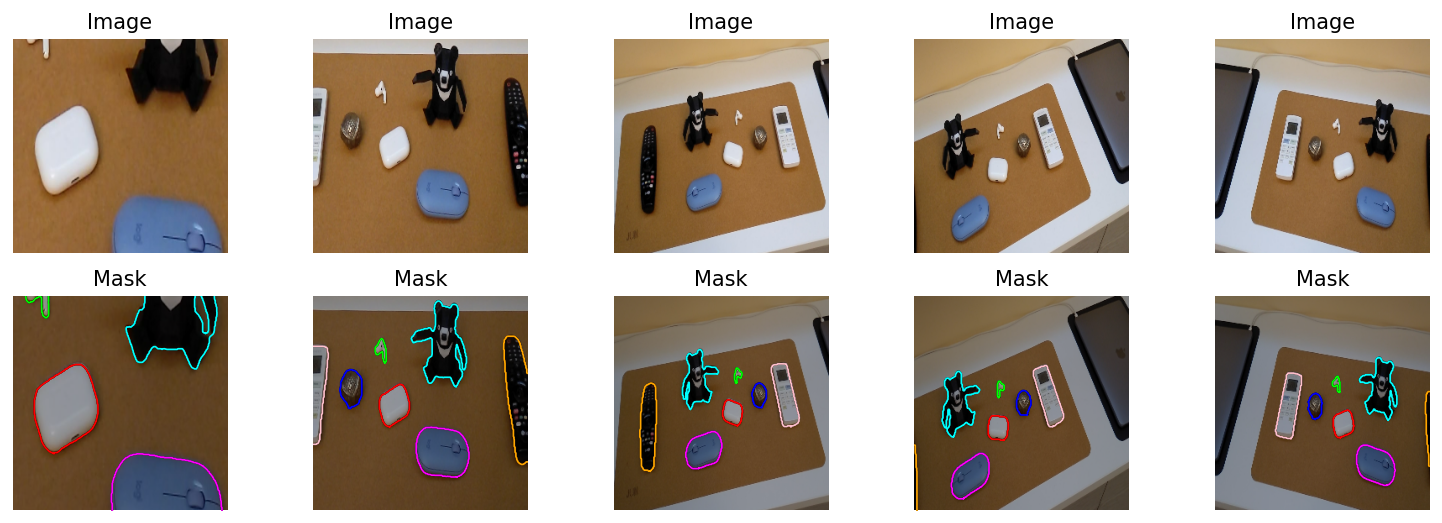

In [8]:
images_and_masks = list(dataset.take(5))

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize=(15, 5), dpi=125)

for i, (image, masks) in enumerate(images_and_masks):
    ax[0, i].set_title('Image')
    ax[0, i].set_axis_off()
    ax[0, i].imshow(image)
        
    ax[1, i].set_title('Mask')
    ax[1, i].set_axis_off()    
    ax[1, i].imshow(image/1.5)
   
    for channel in range(CLASSES):
        contours = measure.find_contours(np.array(masks[:,:,channel]))
        for contour in contours:
            ax[1, i].plot(contour[:, 1], contour[:, 0], linewidth=1, color=COLORS[channel])

plt.show()
plt.close()

## Разделим набор данных на обучающий и проверочный

In [9]:
 # кэшируем их в памяти
train_dataset = dataset.take(2000).cache()
test_dataset = dataset.skip(2000).take(100).cache()
# устанавливаем размер пакета, которым будем обучать нейронную сеть
train_dataset = train_dataset.batch(16)
test_dataset = test_dataset.batch(16)

## Обозначим основные блоки модели

In [10]:
# задаём входной слой нейронной сети и уст. размер входных данных
def input_layer():
    return tf.keras.layers.Input(shape=SAMPLE_SIZE + (3,))

# описываем блоки, которые формирует энкодер
def downsample_block(filters, size, batch_norm=True):
    initializer = tf.keras.initializers.GlorotNormal() # задаём метод инициализации весовых коэффициентов

    result = tf.keras.Sequential()
    
    # включаем свёрточный слой
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    # добавляем слой пакетной нормализации
    if batch_norm:
        result.add(tf.keras.layers.BatchNormalization())
    
    # устанавливаем активационную функцию
    result.add(tf.keras.layers.LeakyReLU())
    return result

# помогает формировать декодер нейросети
def upsample_block(filters, size, dropout=False):
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()
    
    # функция противоположная свёртке
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                        kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
    
    if dropout:
        result.add(tf.keras.layers.Dropout(0.25))
    
    result.add(tf.keras.layers.ReLU())
    return result

# задаём выходной слой, используем сигмоидную активационную функцию
def output_layer(size):
    initializer = tf.keras.initializers.GlorotNormal()
    return tf.keras.layers.Conv2DTranspose(CLASSES, size, strides=2, padding='same',
                                           kernel_initializer=initializer, activation='sigmoid')

## Построим U-NET подобную архитектуру

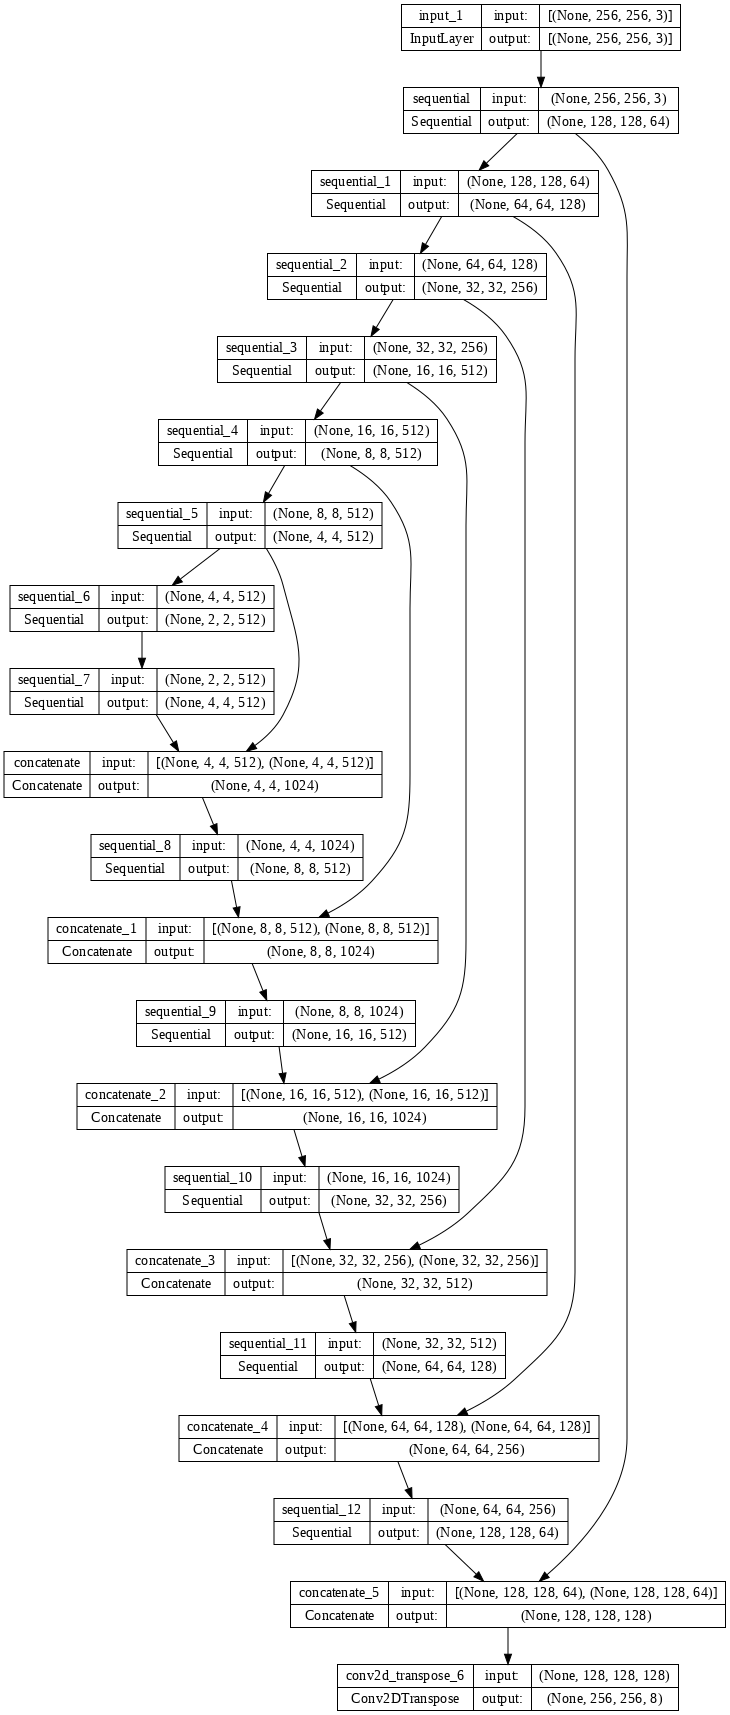

In [11]:
inp_layer = input_layer()

# массив, который представляет энкодер
downsample_stack = [
    downsample_block(64, 4, batch_norm=False),
    downsample_block(128, 4),
    downsample_block(256, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
]

# массив, который представляет декодер
upsample_stack = [
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(256, 4),
    upsample_block(128, 4),
    upsample_block(64, 4)
]
# такая структура данных нужна для простой реализации skip connection

out_layer = output_layer(4)

# Реализуем skip connections
x = inp_layer

downsample_skips = []

# с помощью циклов соединяем блоки энкодера и декодера друг с другом
for block in downsample_stack:
    x = block(x)
    downsample_skips.append(x)
    
downsample_skips = reversed(downsample_skips[:-1])

for up_block, down_block in zip(upsample_stack, downsample_skips):
    x = up_block(x)
    x = tf.keras.layers.Concatenate()([x, down_block]) # с помощью конкатенации реализуем межслоевые соединения

out_layer = out_layer(x)

# создаем модель в которой указываем входные и выходные слои
unet_like = tf.keras.Model(inputs=inp_layer, outputs=out_layer)

tf.keras.utils.plot_model(unet_like, show_shapes=True, dpi=72)

## Определим метрики и функции потерь

In [12]:
# оценка точности результатов работы нейросети
def dice_mc_metric(a, b): # 1 параметр - ответ нейросети, 2 параметр - результат, который должен получиться на самом деле
    a = tf.unstack(a, axis=3) # распаковываем многоканальные изображения маски
    b = tf.unstack(b, axis=3) # распаковываем многоканальные изображения маски
    
    dice_summ = 0
    
    # находим среднее значение коэффициента dice по всем классам объектов, которые присутствуют на сцене
    for i, (aa, bb) in enumerate(zip(a, b)):
        numenator = 2 * tf.math.reduce_sum(aa * bb) + 1
        denomerator = tf.math.reduce_sum(aa + bb) + 1
        dice_summ += numenator / denomerator
        
    avg_dice = dice_summ / CLASSES
    
    return avg_dice

# функция потерь
def dice_mc_loss(a, b):
    return 1 - dice_mc_metric(a, b)

# комбинированная функция
def dice_bce_mc_loss(a, b):
    return 0.3 * dice_mc_loss(a, b) + tf.keras.losses.binary_crossentropy(a, b) # сумма двух функций. С помощью коэффициента 0.3 уменьшаем влияние функции dice

## Компилируем модель

In [13]:
unet_like.compile(optimizer='adam', loss=[dice_bce_mc_loss], metrics=[dice_mc_metric])

## Обучаем нейронную сеть и сохраняем результат

In [14]:
history_dice = unet_like.fit(train_dataset, validation_data=test_dataset, epochs=25, initial_epoch=0) # 25 эпох хватает чтобы нейросеть показывала приемлемые результаты

unet_like.save_weights('neural_network/networks/unet_like') # после обучения сохраняем модель в файл

Epoch 1/25
125/125 [==============================] - 675s 5s/step - loss: 0.2578 - dice_mc_metric: 0.4606 - val_loss: 0.6511 - val_dice_mc_metric: 0.2195
Epoch 2/25
125/125 [==============================] - 37s 296ms/step - loss: 0.0715 - dice_mc_metric: 0.8163 - val_loss: 2.1783 - val_dice_mc_metric: 0.1523
Epoch 3/25
125/125 [==============================] - 36s 288ms/step - loss: 0.0225 - dice_mc_metric: 0.9501 - val_loss: 0.0345 - val_dice_mc_metric: 0.9175
Epoch 4/25
125/125 [==============================] - 36s 290ms/step - loss: 0.0151 - dice_mc_metric: 0.9676 - val_loss: 0.0318 - val_dice_mc_metric: 0.9259
Epoch 5/25
125/125 [==============================] - 36s 290ms/step - loss: 0.0124 - dice_mc_metric: 0.9739 - val_loss: 0.0176 - val_dice_mc_metric: 0.9603
Epoch 6/25
125/125 [==============================] - 36s 290ms/step - loss: 0.0108 - dice_mc_metric: 0.9774 - val_loss: 0.0124 - val_dice_mc_metric: 0.9735
Epoch 7/25
125/125 [==============================] - 36s 29

## Загрузим модель

In [15]:
unet_like.load_weights('neural_network/networks/unet_like')

## Проверим работу сети на всех кадрах из видео

In [16]:
rgb_colors = [
    (0,   0,   0),
    (255, 0,   0),
    (0,   255, 0),
    (0,   0,   255),
    (255, 165, 0),
    (255, 192, 203),
    (0,   255, 255),
    (255, 0,   255)
]

frames = sorted(glob.glob('neural_network/videos/original_video/*.jpg'))

for filename in frames:
    frame = imread(filename)
    sample = resize(frame, SAMPLE_SIZE)
    
    predict = unet_like.predict(sample.reshape((1,) +  SAMPLE_SIZE + (3,)))
    predict = predict.reshape(SAMPLE_SIZE + (CLASSES,))
        
    scale = frame.shape[0] / SAMPLE_SIZE[0], frame.shape[1] / SAMPLE_SIZE[1]
    
    frame = (frame / 1.5).astype(np.uint8)
    
    for channel in range(1, CLASSES): 
        contour_overlay = np.zeros((frame.shape[0], frame.shape[1]))
        contours = measure.find_contours(np.array(predict[:,:,channel]))
        
        try:
            for contour in contours:
                rr, cc = polygon_perimeter(contour[:, 0] * scale[0],
                                           contour[:, 1] * scale[1],
                                           shape=contour_overlay.shape)
                
                contour_overlay[rr, cc] = 1        
            
            contour_overlay = dilation(contour_overlay, disk(1))
            frame[contour_overlay == 1] = rgb_colors[channel]
        except:
            pass

    imsave(f'neural_network/videos/processed/{os.path.basename(filename)}', frame)

1/1 [==============================] - 0s 23ms/step
